In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

import itertools
plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 20.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'

mpl.rcParams['legend.fontsize'] = 'medium'

mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.titleweight'] = 'heavy'

# print(mpl.rcParams.keys())


In [2]:

############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 1.0 # -> 15ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)




In [3]:
############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))






#define the kernels (assuming that they fold over 16 freq_bands)
# x =  np.linspace(0,freq_bands,freq_bands)
# cf = 8



In [4]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.jet,
        shade=True,
        linewidth=20)

    return ax


#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    # build a threshold. make sure we do not change the original array (called by reference)
    if isinstance(r_bpc, (list,np.ndarray)):
        tmp = 1.0*r_bpc
        tmp[tmp < 0.00] = 0.0
    else:
        if r_bpc < 0.00:
            tmp = 0.0
        else:
            tmp = r_bpc
    
    return 1 / (1 + np.exp(-(tmp-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    ## Defines a threshold ?
    q_pc[q_pc < 0.000] = 0.0
    return np.maximum(q_pc,0)

# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,bias,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    
    ee_kernel  = np.maximum((ee_kernel- gaba_exc),0.01)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) # *1/(gaba_exc +1.0) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = np.maximum((ei_kernel- gaba_inh),0.01)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(gaba_inh+1.0)       
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
    
#     excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) 1
#     # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
#     inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel))     
#     # calculate the change of r_bpc
#     d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - (gamma_r + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return  d_q_pc  / tau_r


# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p

In [5]:



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r =1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0








## Stimuli  Influence on LSP Response

In [6]:
gbc_offsets = np.array(np.arange(-100,200,10))
#gbc_input_intensities = np.array([1.0,2.5,5.0,7.5,10.0])
sbc_input_intensities = np.array([0.5])
gbc_input_intensities = np.array([0,0.07,0.17,0.27,0.37,0.47,0.57])
gbc_input_intensities = np.linspace(0,0.5,10)
gbc_input_intensities = np.append(gbc_input_intensities,0.5)
gbc_input_intensities = np.append(gbc_input_intensities,np.linspace(0.5,1.0,10))

sbc_input_intensities = np.linspace(1,0.5,10)
sbc_input_intensities = np.append(sbc_input_intensities,0.5)
sbc_input_intensities = np.append(sbc_input_intensities,np.linspace(0.5,0.0,10))


# store the solutions
q_all = np.zeros((len(gbc_offsets),len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(gbc_offsets),len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(gbc_offsets),len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0

for l in range(len(gbc_offsets)):
    for k in range(len(gbc_input_intensities)):



        ############################################################
        #                       Inputs                             #
        ############################################################
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 30.0

        
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))
        
        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 200
        gbc_input_duration = 200
        gbc_input_offset = gbc_offsets[l]
        gbc_center_frequencyBand = 3
        gbc_input_strength = gbc_input_intensities[k]
        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        gbc_gauss_mask = gauss(np.arange(gbc_input_duration),gbc_input_duration/2,sigma)
        # build a plateau at the end to let the neurons go to a steady state


        s_gbc_all[gbc_input_onset+gbc_input_offset:gbc_input_onset+gbc_input_offset+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask
        s_gbc_all[gbc_input_onset+gbc_input_offset+200:gbc_input_onset+gbc_input_offset+200+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask
        s_gbc_all[gbc_input_onset+gbc_input_offset+400:gbc_input_onset+gbc_input_offset+400+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask
#         s_gbc_all[gbc_input_onset+gbc_input_offset-200:gbc_input_onset+gbc_input_offset-200+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask

        sigma_neighbor = 1.0
        gbc_gauss_mask = gauss(np.arange(freq_bands),gbc_center_frequencyBand,sigma_neighbor)



        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 200
        sbc_input_duration = 200
        sbc_input_offset = 0
        sbc_center_frequencyBand = 3
        sbc_input_strength = sbc_input_intensities[k]

        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        sbc_gauss_mask = gauss(np.arange(sbc_input_duration),sbc_input_duration/2,sigma)
        # build a plateau at the end to let the neurons go to a steady state


#         s_sbc_all[sbc_input_onset+sbc_input_offset:sbc_input_onset+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask
        s_sbc_all[sbc_input_onset+200+sbc_input_offset:sbc_input_onset+200+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask
#         s_sbc_all[sbc_input_onset+400+sbc_input_offset:sbc_input_onset+400+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask
#         s_sbc_all[sbc_input_onset-200+sbc_input_offset:sbc_input_onset-200+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask

        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
#         s_gbc_all /= maxi
#         s_sbc_all /= maxi



        ############################################################
        #                      Simulation                          #
        ############################################################



        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)
                
                gaba_inh_values[i,w] =   p_all[l,k,i,w]*1
                gaba_exc_values[i,w] =   p_all[l,k,i,w]*5

                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                delay_factor = 20
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])     
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])        
                
                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)
    
                p_all[l,k,i+1,w] = p_all[l,k,i,w] + dt * ode_p_pc(p_all[l,k,i,w],g_r_out(r_all[l,k,i,w]))



        # remove delay input from MNTB
        #s_gbc_all = np.roll(s_gbc_all,-delay_factor,axis=0)

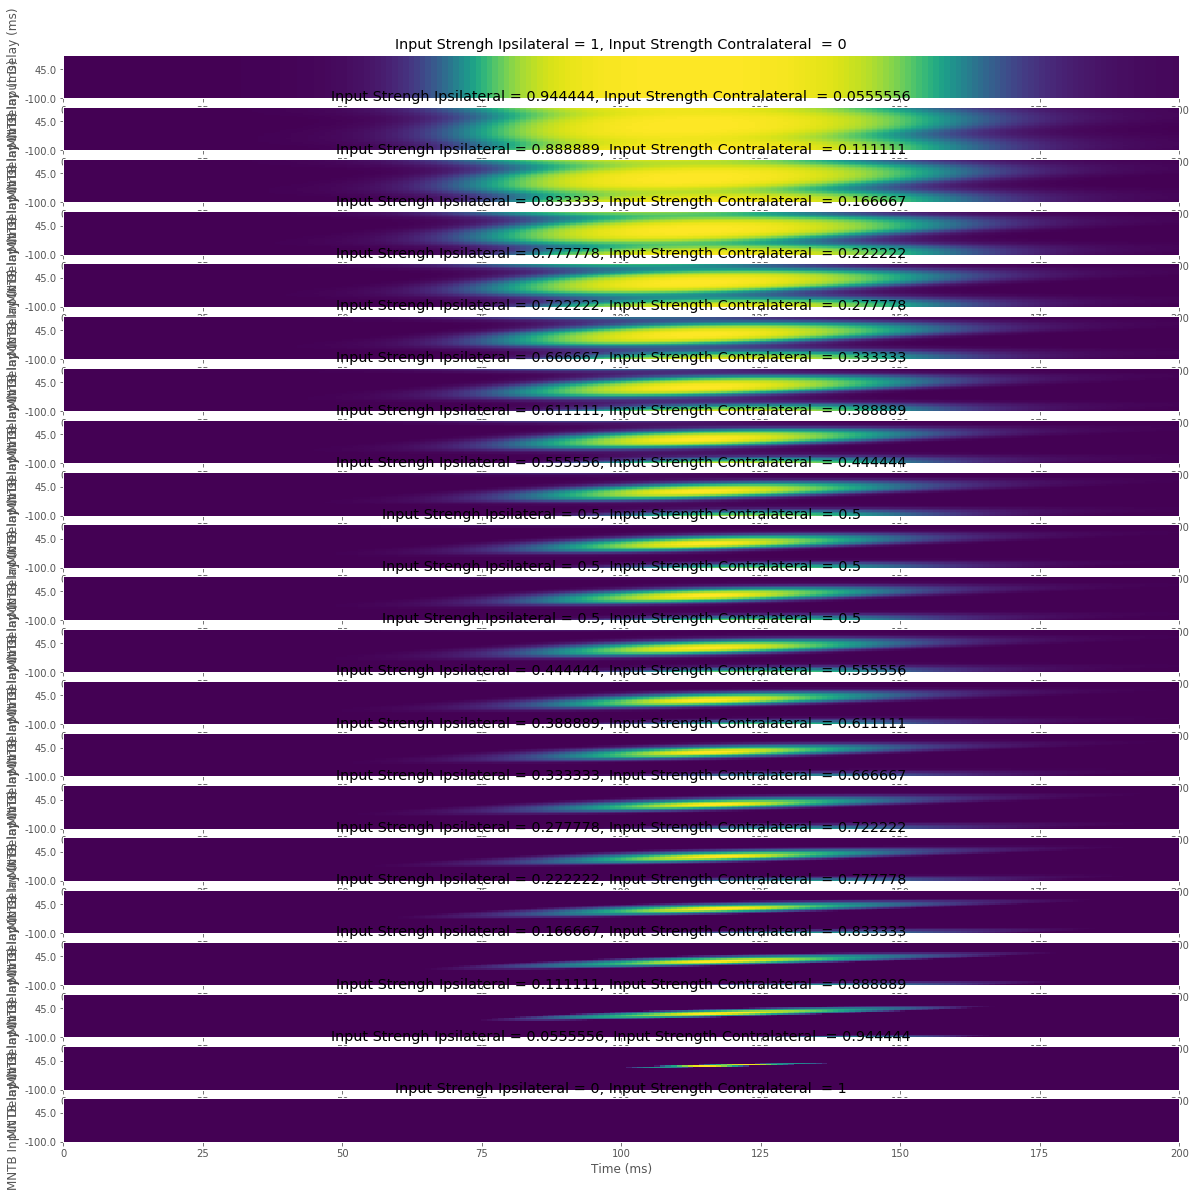

In [7]:
############################################################
#                       Plotting                           #
############################################################





fig = plt.figure(figsize=(20,20))
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
#plt.suptitle(stri,fontsize=16)
#r = r_all[:,:,500:900,3]
r = r_all[:,:,:,3]


for i in range(r.shape[1]):
    ax1 = plt.subplot2grid((r.shape[1], 1), (i, 0), colspan=2)
    ax1.pcolor(g_r_out(r[:,i,400:600]))
    #ax1.axhline(y=80-25, xmin=0.0, xmax=1.0, color='white',linestyle='--')    
    plt.title('Input Strengh Ipsilateral = {0:g}, Input Strength Contralateral  = {1:g}'.format(sbc_input_intensities[i],gbc_input_intensities[i]))
    plt.ylabel('MNTB Input Delay (ms)')
    tmp = gbc_offsets[::int((len(gbc_offsets)/len(ax1.get_yticks())))+5]
    ax1.set_yticklabels(np.linspace(gbc_offsets[0],gbc_offsets[-1],len(ax1.get_yticks())))
#     ax1.set_xticklabels(ax1.get_xticks()/100)
#     plt.tight_layout()
    plt.xlabel('Time (ms)')

plt.show()


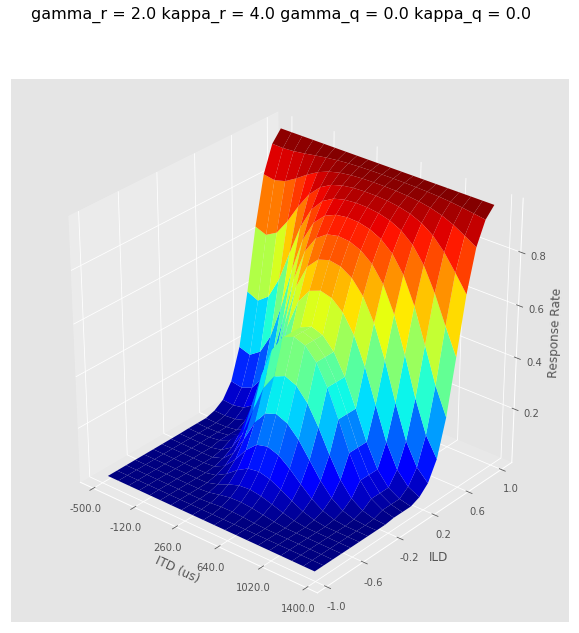

In [37]:
fig = plt.figure(figsize=(10,10))
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

r = g_r_out(r_all[:,:,:,3])
q = q_all[:,:,:,3]


ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=2,projection='3d')
mesh_plot(r[5:25,:,500],ax1)
ax1.view_init(elev=30., azim=-50)
plt.ylabel('ILD')
plt.xlabel('ITD (us)')
ax1.set_zlabel('Response Rate')
# ax1.set_xticklabels(gbc_offsets[5:25:5])
ild_ticks = gbc_input_intensities-sbc_input_intensities
ild_ticks = np.linspace(np.min(ild_ticks),np.max(ild_ticks),len(ax1.get_yticks())-2)
ax1.set_yticklabels(['{0:.1f}'.format(-i) for i in ild_ticks])

itd_ticks = gbc_offsets[5:25]
itd_ticks = np.linspace(np.min(itd_ticks),np.max(itd_ticks),len(ax1.get_xticks())-2)
ax1.set_xticklabels(['{0:.1f}'.format(i*10) for i in itd_ticks])
plt.gca().invert_yaxis()

plt.show()

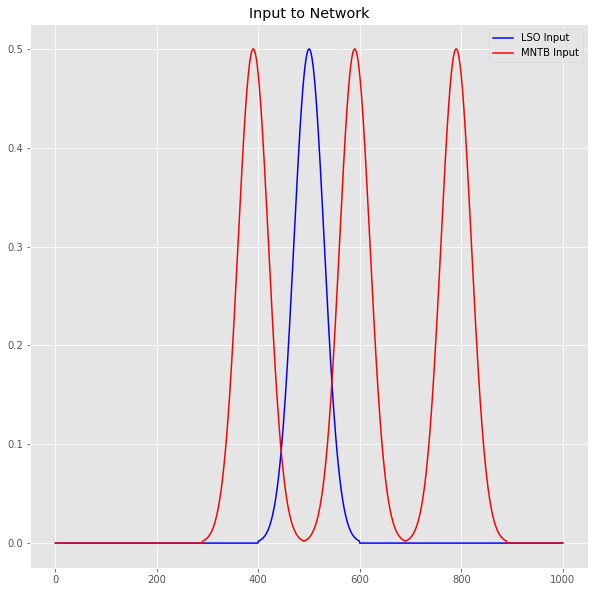

In [48]:
for l in range(len(gbc_offsets)-10):
    for k in range(10):



        ############################################################
        #                       Inputs                             #
        ############################################################
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 30.0

        
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))
        
        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 200
        gbc_input_duration = 200
        gbc_input_offset = gbc_offsets[l]
        gbc_center_frequencyBand = 3
        gbc_input_strength = gbc_input_intensities[k]
        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        gbc_gauss_mask = gauss(np.arange(gbc_input_duration),gbc_input_duration/2,sigma)
        # build a plateau at the end to let the neurons go to a steady state


        s_gbc_all[gbc_input_onset+gbc_input_offset:gbc_input_onset+gbc_input_offset+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask
        s_gbc_all[gbc_input_onset+gbc_input_offset+200:gbc_input_onset+gbc_input_offset+200+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask
        s_gbc_all[gbc_input_onset+gbc_input_offset+400:gbc_input_onset+gbc_input_offset+400+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask
#         s_gbc_all[gbc_input_onset+gbc_input_offset-200:gbc_input_onset+gbc_input_offset-200+gbc_input_duration,gbc_center_frequencyBand] =  gbc_input_strength * gbc_gauss_mask

        sigma_neighbor = 1.0
        gbc_gauss_mask = gauss(np.arange(freq_bands),gbc_center_frequencyBand,sigma_neighbor)



        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 200
        sbc_input_duration = 200
        sbc_input_offset = 0
        sbc_center_frequencyBand = 3
        sbc_input_strength = sbc_input_intensities[k]

        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        sbc_gauss_mask = gauss(np.arange(sbc_input_duration),sbc_input_duration/2,sigma)
        # build a plateau at the end to let the neurons go to a steady state


#         s_sbc_all[sbc_input_onset+sbc_input_offset:sbc_input_onset+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask
        s_sbc_all[sbc_input_onset+200+sbc_input_offset:sbc_input_onset+200+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask
#         s_sbc_all[sbc_input_onset+400+sbc_input_offset:sbc_input_onset+400+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask
#         s_sbc_all[sbc_input_onset-200+sbc_input_offset:sbc_input_onset-200+sbc_input_offset+sbc_input_duration,sbc_center_frequencyBand] =  sbc_input_strength * sbc_gauss_mask

        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
#         s_gbc_all /= maxi
#         s_sbc_all /= maxi




fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=2)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
plt.title('Input to Network')
plt.legend()
plt.show()

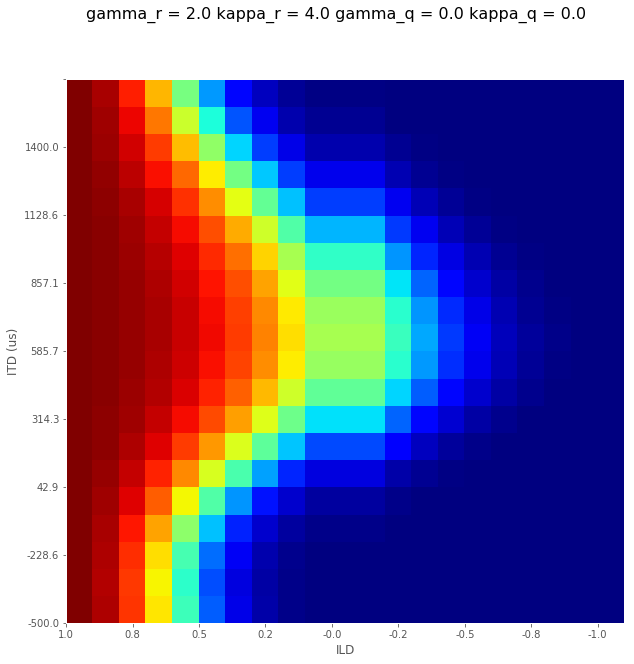

In [38]:
fig = plt.figure(figsize=(10,10))
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

r = g_r_out(r_all[:,:,:,3])
q = q_all[:,:,:,3]

from matplotlib import cm

ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=2)
ax1.pcolor(r[5:25,:,500],cmap=cm.jet)
plt.xlabel('ILD')
plt.ylabel('ITD (us)')
# ax1.set_xticklabels(gbc_offsets[5:25:5])
ild_ticks = gbc_input_intensities-sbc_input_intensities
ild_ticks = np.linspace(np.min(ild_ticks),np.max(ild_ticks),len(ax1.get_yticks()))
ax1.set_xticklabels(['{0:.1f}'.format(-i) for i in ild_ticks])

itd_ticks = gbc_offsets[5:25]
itd_ticks = np.linspace(np.min(itd_ticks),np.max(itd_ticks),len(ax1.get_xticks())-2)
ax1.set_yticklabels(['{0:.1f}'.format(i*10) for i in itd_ticks])
# plt.gca().invert_yaxis()

plt.show()




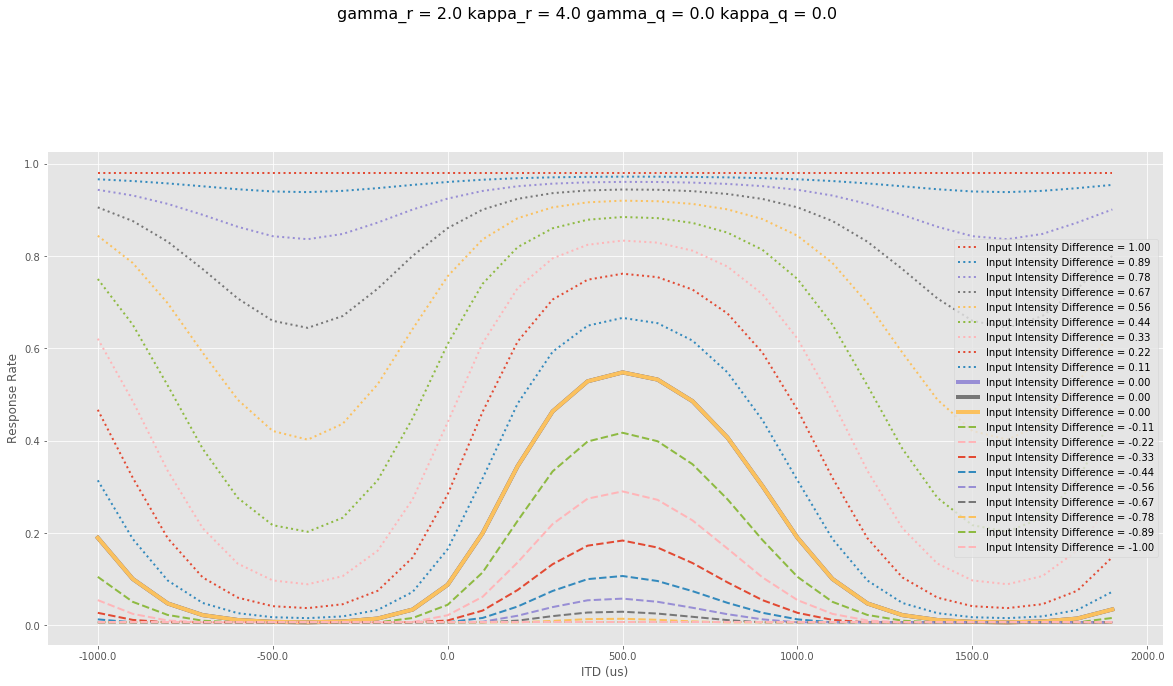

In [9]:
fig = plt.figure(figsize=(20,20))
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

r = g_r_out(r_all[:,:,:,3])
q = q_all[:,:,:,3]

ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=2)
for i in range(r.shape[1]):
    level_diff = sbc_input_intensities[i] - gbc_input_intensities[i]
    if level_diff < 0:
        line_style = '--'
        line_width = 2
    elif level_diff == 0:
        line_style = '-'
        line_width = 4
    else:
        line_style = ':'
        line_width = 2

    ax1.plot(gbc_offsets[:],r[:,i,500],linewidth=line_width,linestyle=line_style,label='Input Intensity Difference = {0:.2f}'.format(level_diff))

plt.xlabel('ITD (us)')
plt.ylabel('Response Rate')
ax1.set_xticklabels(ax1.get_xticks()*10)
plt.legend()
plt.show()


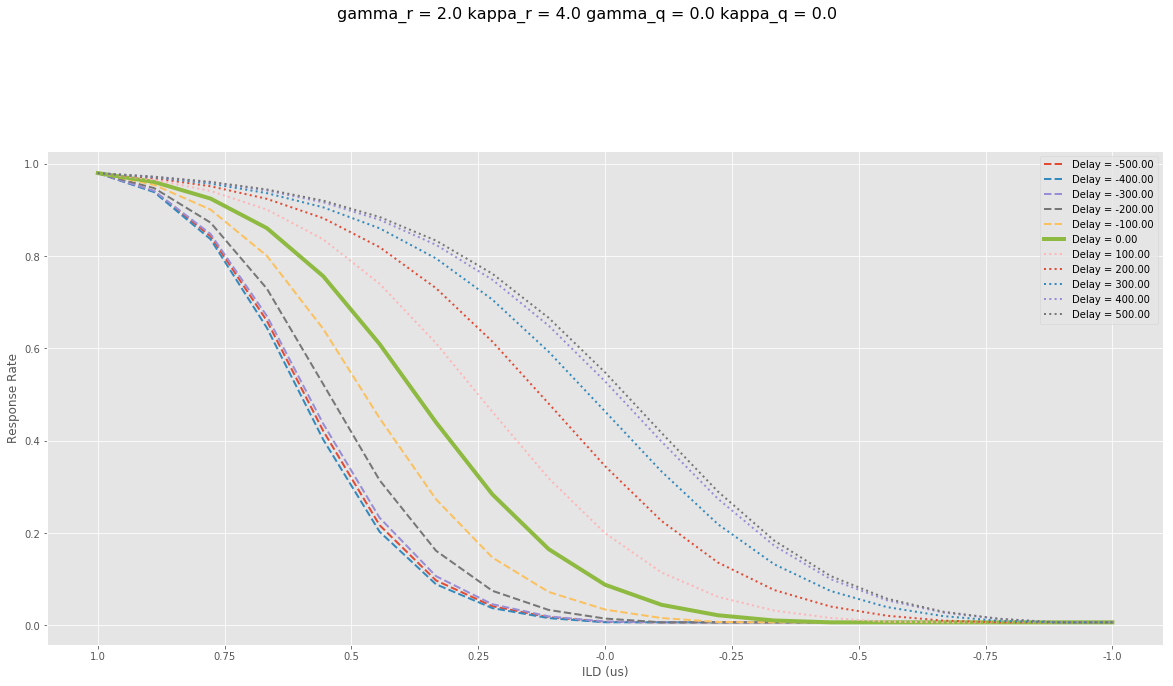

In [10]:
fig = plt.figure(figsize=(20,20))
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

r = g_r_out(r_all[:,:,:,3])
q = q_all[:,:,:,3]
ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=2)
for i in range(5,r.shape[0]-14):
    
    if gbc_offsets[i] < 0:
        line_style = '--'
        line_width = 2
    elif gbc_offsets[i] == 0:
        line_style = '-'
        line_width = 4
    else:
        line_style = ':'
        line_width = 2
    ax1.plot((gbc_input_intensities-sbc_input_intensities),r[i,:,500],linewidth=line_width,linestyle=line_style,label='Contra-lateral Delay = {0:.2f}'.format(gbc_offsets[i]*10))

ax1.set_xticklabels(ax1.get_xticks()*-1)
plt.xlabel('ILD')
plt.ylabel('Response Rate')
plt.legend()
plt.show()

In [ ]:
%matplotlib inline

Here we plot the LSO response for various time delays for an input difference of __zero__

(200, 21, 20)


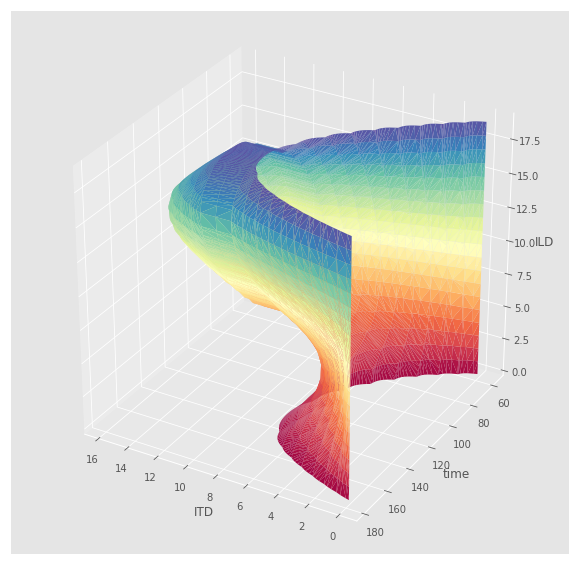

In [66]:
r = g_r_out(r_all[:,:,:,:])

vol =g_r_out(r[5:25,0:,400:600,3])
vol =np.transpose(g_r_out(r[5:25,0:,400:600,3]),[2,1,0])

print(vol.shape)
verts = None
faces = None
verts, faces = measure.marching_cubes_classic(vol, spacing=(1.0, 1.0, 1.0),level=0.05,gradient_direction='descent')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(
    verts[:, 1], verts[:, 0], faces, verts[:, 2], cmap='Spectral', lw=0.0)
ax.view_init(elev=30., azim=120)

ax.set_ylabel('time')
ax.set_xlabel('ITD')
ax.set_zlabel('ILD')
plt.show()